In [1]:
import uproot
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit, minimize
from scipy.stats import argus
from scipy.integrate import quad
from numpy import  log, sqrt, exp, pi, e
import multiprocessing
import os
from numba import njit
from source import *

/tmp/ipykernel_9950/2585866041.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from matplotlib.axes import Axes

class CustomedAxes(Axes):
    def errorhist(self, data, bins=10, fmt='.', color='dimgrey', err_func = np.sqrt, **kwargs):
        counts, bin_edges = np.histogram(data, bins=bins, **kwargs)
        bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
        self.errorbar(bin_centers, counts, yerr=err_func(counts), fmt=fmt, color=color, capsize=5, **kwargs)
        return counts, bin_centers

__subplot = plt.subplots

def subplots(nrows=1, ncols=1, **kwargs):
    fig, axes = __subplot(nrows=nrows, ncols=ncols, **kwargs)
    if isinstance(axes, np.ndarray):
        custom_axes = []
        for ax in axes.flat:
            position = ax.get_position()
            ax.remove() 
            custom_ax = CustomedAxes(fig, position)
            fig.add_axes(custom_ax)
            custom_axes.append(custom_ax)
        custom_axes = np.array(custom_axes).reshape(axes.shape)
    else:
        position = axes.get_position()
        axes.remove()
        custom_axes = CustomedAxes(fig, position)
        fig.add_axes(custom_axes)
    return fig, custom_axes

plt.subplots = subplots

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams['axes.titlesize'] = 22 

/home/mar/Documents/data_ref/source.py:112: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.7346902276940925
       x: [ 8.010e+00  1.003e+00  1.048e+00  2.034e+00  3.005e-01]
     nit: 14
     jac: [-1.910e-04  3.833e-04  2.008e-04 -4.589e-04 -1.816e-04]
    nfev: 87
    njev: 14


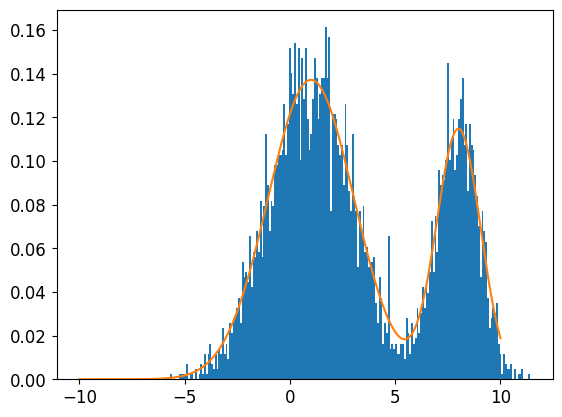

In [3]:
N = 5000
tau = 0.3
x = np.concatenate((np.random.normal(8, 1, int(N*tau)), np.random.normal(1, 2, int(N*(1-tau)))))
plt.hist(x, density=True, bins=200)
counts, bin_edges = np.histogram(x, bins=15)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
f = lambda x, mu1, mu2, s1, s2, tau: gaussian(x, mu1, s1)*tau + gaussian(x, mu2, s2)*(1-tau)
args, _ = max_bin_lik(f, bin_centers, counts, (8, 2, 1, 1, 0.5))
xx = np.linspace(-10, 10, 1000)
plt.plot(xx, f(xx, *args))

In [4]:
fname = "mc.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
mc = tupl2.arrays(library='pd')

['en', 'nen', 'ecm', 'p', 'np', 'ntr', 'en_gam', 'enc_gam', 'chxc', 'pxc', 'npxc', 'mxc', 'chach', 'mach', 'nmach', 'machdt', 'chlc', 'mlc', 'plc', 'nmlc', 'ang_l_xc', 'nang_l_x', 'ang_lc_l', 'ang_l_p', 'p_prot', 'p_lam', 'rm2n', 'nrm2n', 'rm2l', 'nrm2l', 'pn', 'npn', 'rm2nu', 'nrm2nu', 'fnrm2nu', 'chi', 'q2', 'tr_lc', 'tr_ach', 'miss_ach', 'miss_lc']


In [5]:
fname = "data.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
re = tupl2.arrays(library='pd')

['en', 'nen', 'ecm', 'p', 'np', 'ntr', 'en_gam', 'enc_gam', 'chxc', 'pxc', 'npxc', 'mxc', 'chach', 'mach', 'nmach', 'machdt', 'chlc', 'mlc', 'plc', 'nmlc', 'ang_l_xc', 'nang_l_x', 'ang_lc_l', 'ang_l_p', 'p_prot', 'p_lam', 'rm2n', 'nrm2n', 'rm2l', 'nrm2l', 'pn', 'npn', 'rm2nu', 'nrm2nu', 'fnrm2nu', 'chi', 'q2', 'tr_lc', 'tr_ach', 'miss_ach', 'miss_lc']


In [6]:
fname = "inclusive_data.root"
tupl2 = uproot.open(fname)['h1']
tkeys = tupl2.keys()
print(tkeys)
inc = tupl2.arrays(library='pd')

['ecm', 'rm2l', 'dsm', 'dm', 'dsp', 'dp', 'ntr', 'chxc']


In [7]:
fname = "inclusive_data.root"
tupl2 = uproot.open(fname)['h2']
tkeys = tupl2.keys()
print(tkeys)
firs = tupl2.arrays(library='pd')

['ecm', 'en', 'rm2l', 'dsm', 'dm', 'dsp', 'dp', 'ntr', 'chxc', 'chlc', 'mlc', 'rm2n', 'rm2nu', 'q2']


In [8]:
path = "res//"

In [9]:
decay_mod_taging = ["$X_c \\to D^0 p$", "$X_c \\to D^+ p \\pi^- $", "$X_c \\to D^{*0} p$", "$X_c \\to D^{*+} p \\pi^-$", "$X_c \\to \\Lambda_c^- \\pi^- \\pi^+$"]
decay_mod_tag = {"\\Lambda \\nu_l l": [lambda x: x <= 2, "L_nu_l"], "\\Lambda \\pi" : [lambda x: x == 3, "L_pi"], "p K \\pi" : [lambda x: x == 5, "p_k_pi"]}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([ 29.,  32.,  36.,  33.,  37.,  32.,  45.,  49.,  57.,  57.,  65.,
         92.,  96.,  88.,  89., 102., 103., 130., 128., 141., 139., 168.,
        178., 160., 182., 193., 233., 253., 267., 296., 313., 351., 416.,
        393., 372., 440., 447., 493., 503., 550., 562., 603., 679., 721.]),
 array([1.48645997, 1.52282345, 1.55918694, 1.59555042, 1.6319139 ,
        1.66827738, 1.70464087, 1.74100435, 1.77736783, 1.81373131,
        1.8500948 , 1.88645828, 1.92282176, 1.95918524, 1.99554873,
        2.03191221, 2.06827569, 2.10463917, 2.14100266, 2.17736614,
        2.21372962, 2.2500931 , 2.28645658, 2.32282007, 2.35918355,
        2.39554703, 2.43191051, 2.468274  , 2.50463748, 2.54100096,
        2.57736444, 2.61372793, 2.65009141, 2.68645489, 2.72281837,
        2.75918186, 2.79554534, 2.83190882, 2.8682723 , 2.90463579,
        2.94099927, 2.97736275, 3.01372623, 3.05008972, 3.0864532 ]),
 <BarContainer object of 44 artists>)

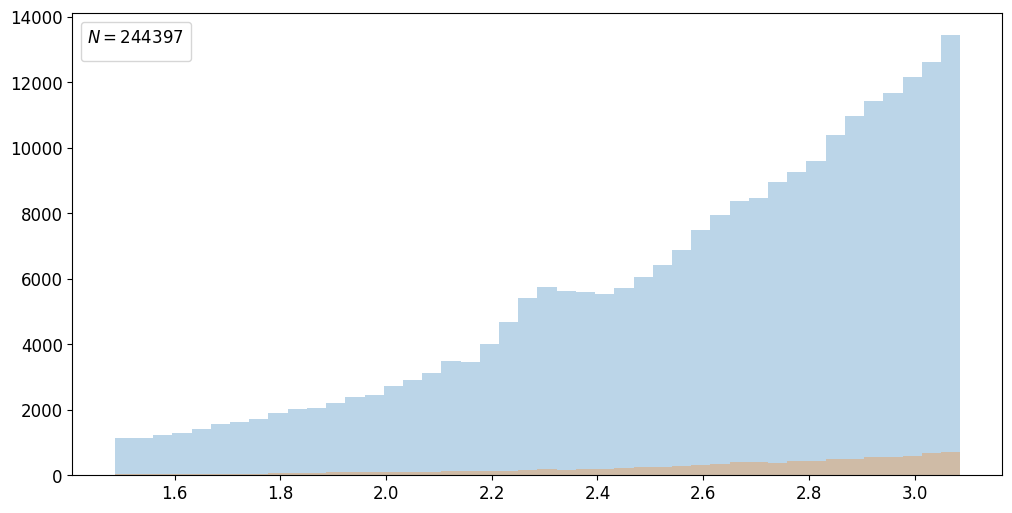

In [10]:
plt.figure(figsize=(12, 6))
dat = inc[(np.abs(inc.rm2l - Lamc_m) < 0.8) & (inc.ntr <= 3) & (inc.chxc >= 3)]
datt = inc[(np.abs(inc.rm2l - Lamc_m) < 0.8) & (inc.ntr > 3) & (inc.chxc >= 3)]
diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), 45)
N = dat.shape[0]
plt.legend(title = f"$N = {N}$")
plt.hist(dat["rm2l"], bins=diw, alpha=0.3)
plt.hist(datt["rm2l"], bins=diw, alpha=0.3)

In [11]:
decay_mod_taging[2]

'$X_c \\to D^{*0} p$'

(array([ 5, 20, 29, 17, 22,  2,  4,  1]),
 array([ 0.875,  2.625,  4.375,  6.125,  7.875,  9.625, 11.375, 13.125]))

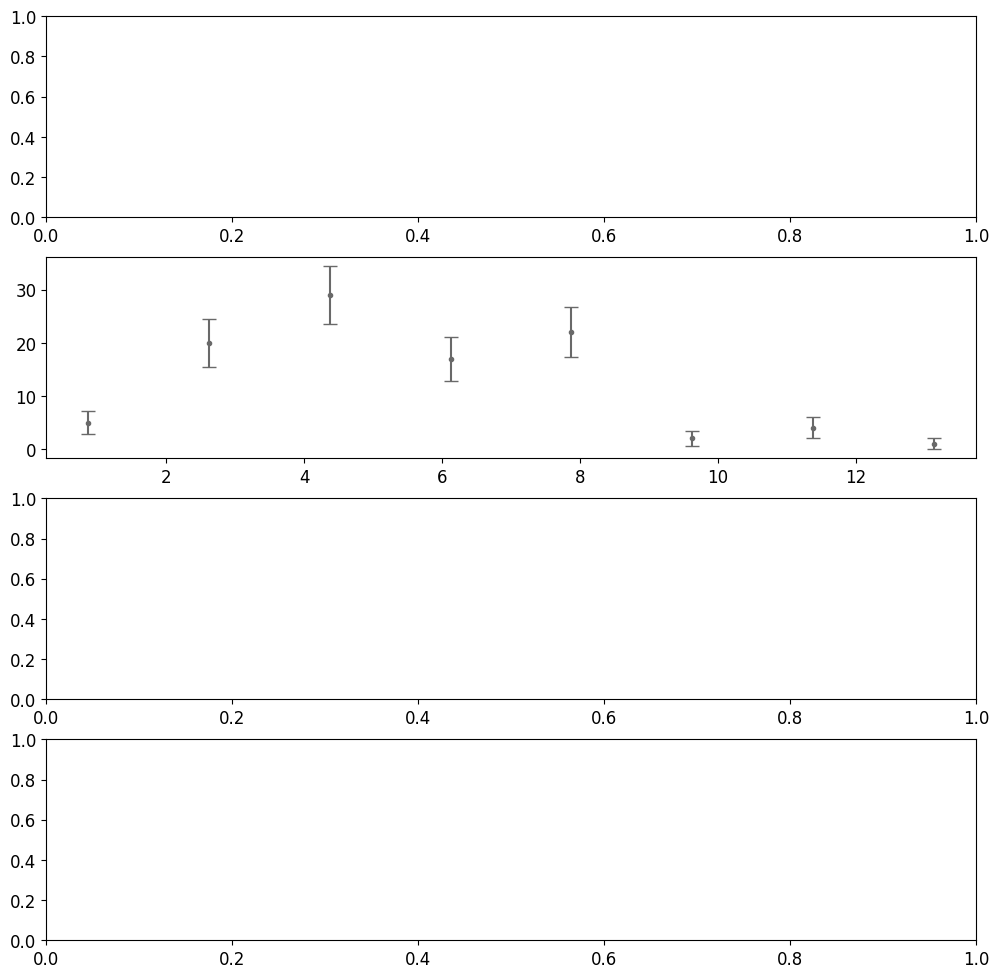

In [14]:

wbin = 0.01
a = 1.6
b = 2.6

fig, ax = plt.subplots(4, figsize=(12, 12))
data = np.random.poisson(5, 100)
ax[1].errorhist(data, bins=8)


In [19]:
class CustomAxes(Axes):
    def errorhist(self, data, bins=10, fmt='.', color='dimgrey', **kwargs):
        counts, bin_edges, _ = np.histogram(data, bins=bins, **kwargs)
        
        bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2

        self.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt=fmt, color=color, capsize=5, **kwargs)
        return counts, bin_centers

In [13]:
def errorhist(data, bins=10, ax=None, fmt='.', color='dimgrey', **kwargs):
    if ax is None:
        ax = plt.gca()
    counts, bin_edges, _ = np.histogram(data, bins=bins, **kwargs)
    
    bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2

    ax.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt=fmt, color=color, capsize=5, **kwargs)
    return counts, bin_centers

def subplots(*args, **kwargs):
    fig, axs = plt.subplots(*args, **kwargs)
    axs = CustomAxes()
    return fig, axs



Axes(0.125,0.712609;0.775x0.167391)
Axes(0.125,0.511739;0.775x0.167391)
Axes(0.125,0.31087;0.775x0.167391)
Axes(0.125,0.11;0.775x0.167391)


AttributeError: 'Axes' object has no attribute 'errorhist'

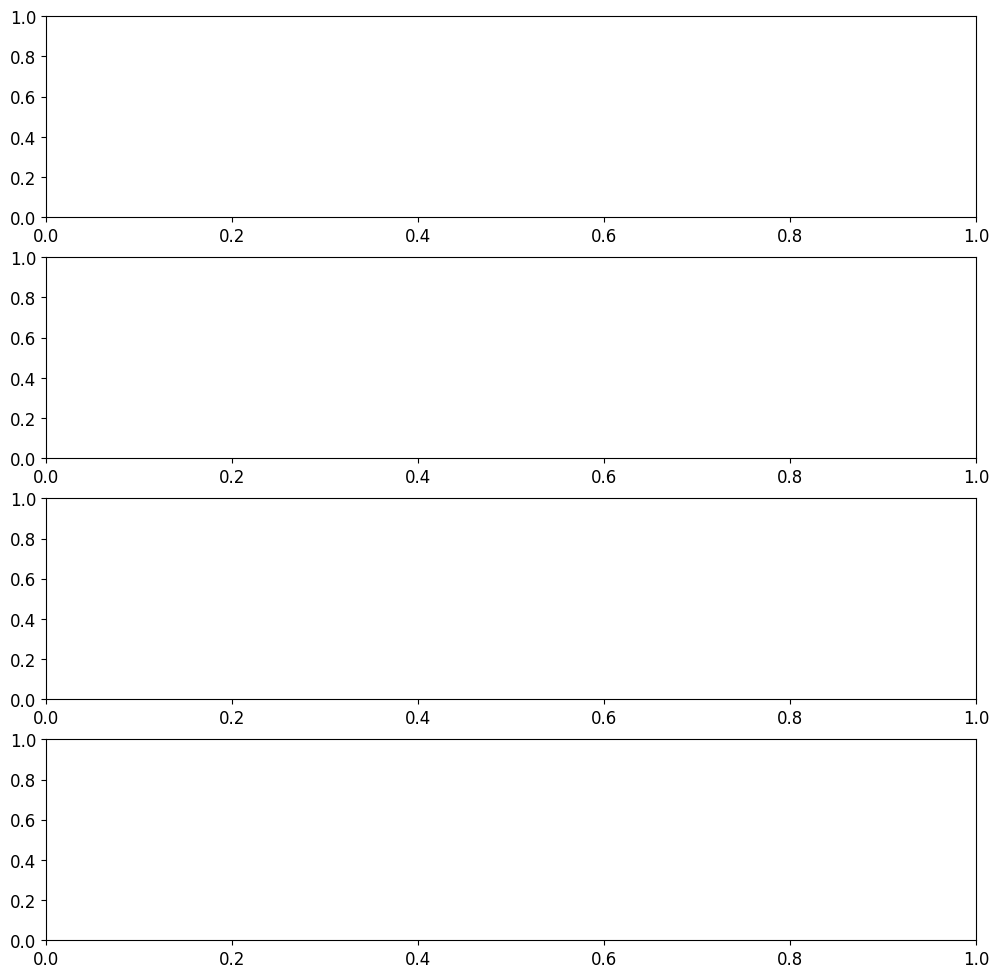

In [21]:
wbin = 0.01
a = 1.6
b = 2.6

fig, axs = plt.subplots(4, figsize=(12, 12))
for ind, i in enumerate([1, 2, 3, 4]):
    dat = inc[(inc.rm2l < b) & (inc.rm2l > a) & (inc.ntr <= 3) & (inc.chxc == i) & (
              ((inc.chxc >= 3) & (np.abs(inc.dsm - inc.dm - 0.142014) < 0.003)) |
              ((inc.chxc <= 2) & (np.abs(inc.dm - D_0_m) < 0.015)))]    
    N = dat.shape[0]
    counts, bin_centers = axs[ind].errorhist(dat, bins=int((b-a)/wbin))
    axs[ind].set_title(decay_mod_taging[ind])    
    axs[ind].grid()

plt.tight_layout()
plt.savefig(f"{path}inc.png")
plt.show()


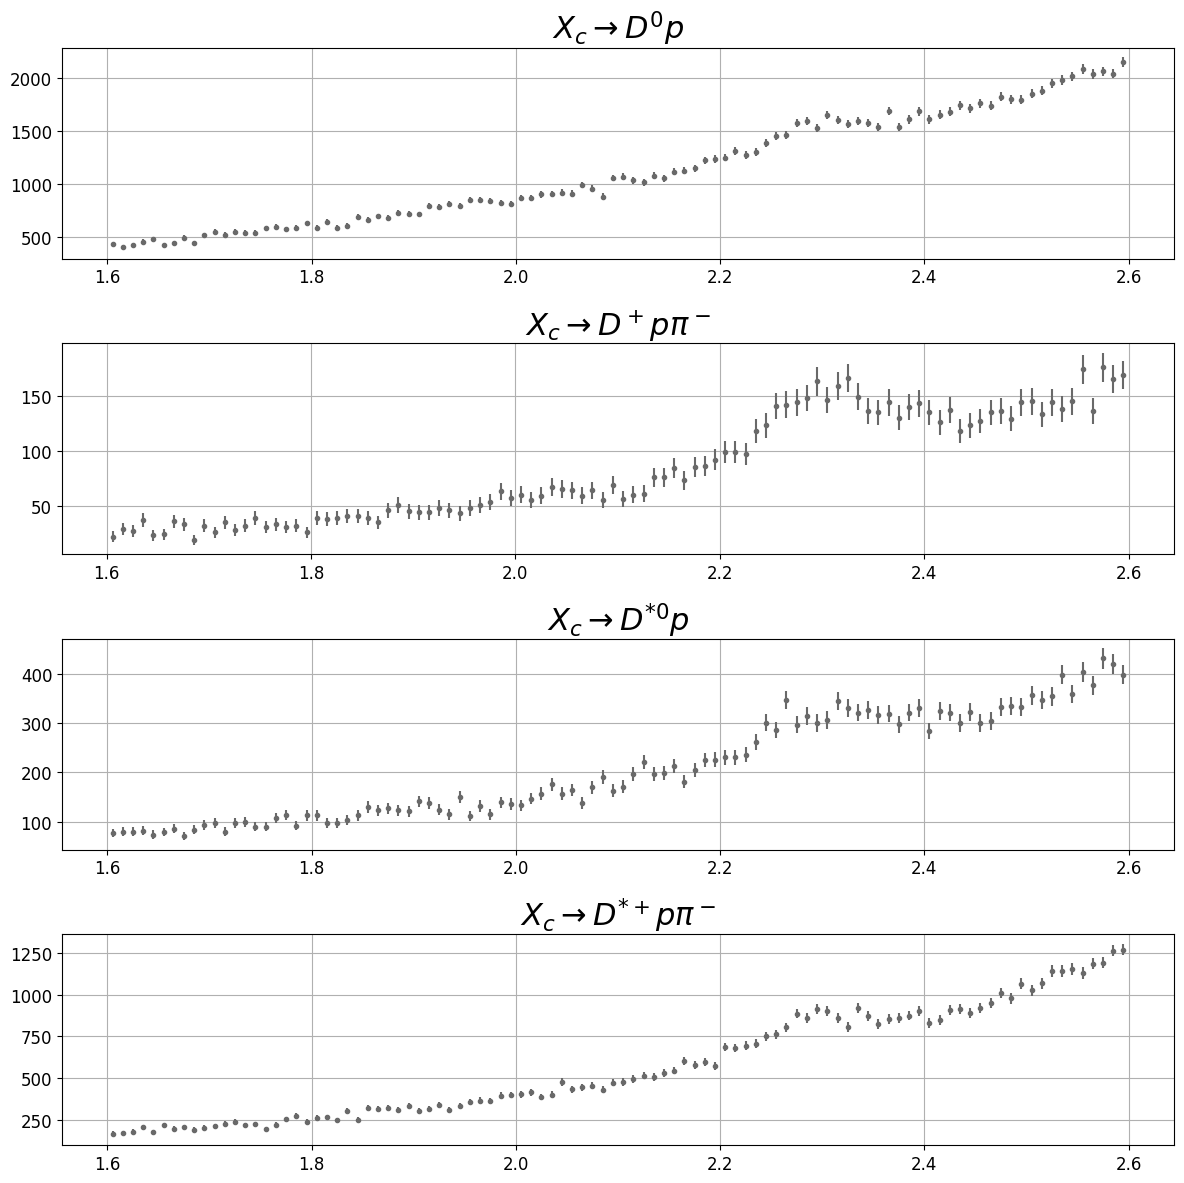

In [17]:
wbin = 0.01
a = 1.6
b = 2.6
fig, axs = plt.subplots(4, figsize=(12, 12))
for ind, i in enumerate([1, 2, 3, 4]):
    dat = inc[(inc.rm2l < b) & (inc.rm2l > a) & (inc.ntr <= 3) & (inc.chxc == i) & (
              ((inc.chxc >= 3) & (np.abs(inc.dsm - inc.dm - 0.142014) < 0.003)) |
              ((inc.chxc <= 2) & (np.abs(inc.dm - D_0_m) < 0.015)))]    
    counts, bin_edges = np.histogram(dat.rm2l, bins=int((b-a)/wbin))
    bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
    N = dat.shape[0]
    axs[ind-1].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')
    axs[ind].set_title(decay_mod_taging[ind])    
    axs[ind-1].grid()
plt.savefig(f"{path}inc.png")
plt.tight_layout()
plt.show()

In [56]:
a = 1.6
b = 3

continuum_lam = njit(lambda x, A1, lam, mu, sig1: A1*np.exp((x-mu)*(lam))*lam / (np.exp(lam * (b - mu)) - np.exp(lam * (a-mu))) + (1-A1)*gaussian(x, 2.65, sig1) )

f_lam = lambda x, A, A1, lam, mu, sig, sig1: A*gaussian(x, Lamc_m, sig) + (1-A)*continuum_lam(x, A1, lam, mu, sig1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 100.00165509027117
       x: [ 1.974e-02  9.611e-01  1.511e+00  9.999e-01  5.707e-02
            1.519e-01]
     nit: 10
     jac: [-2.460e-04 -8.583e-05 -6.771e-05  1.907e-06  4.482e-05
           -6.104e-05]
    nfev: 71
    njev: 10


/home/mar/Documents/data_ref/source.py:112: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 100.00398304767455
       x: [ 4.037e-02  9.456e-01  1.510e+00  1.000e+00  7.886e-02
            1.416e-01]
     nit: 10
     jac: [-1.850e-04 -3.815e-06 -1.230e-04  0.000e+00  1.965e-04
           -4.292e-05]
    nfev: 71
    njev: 10


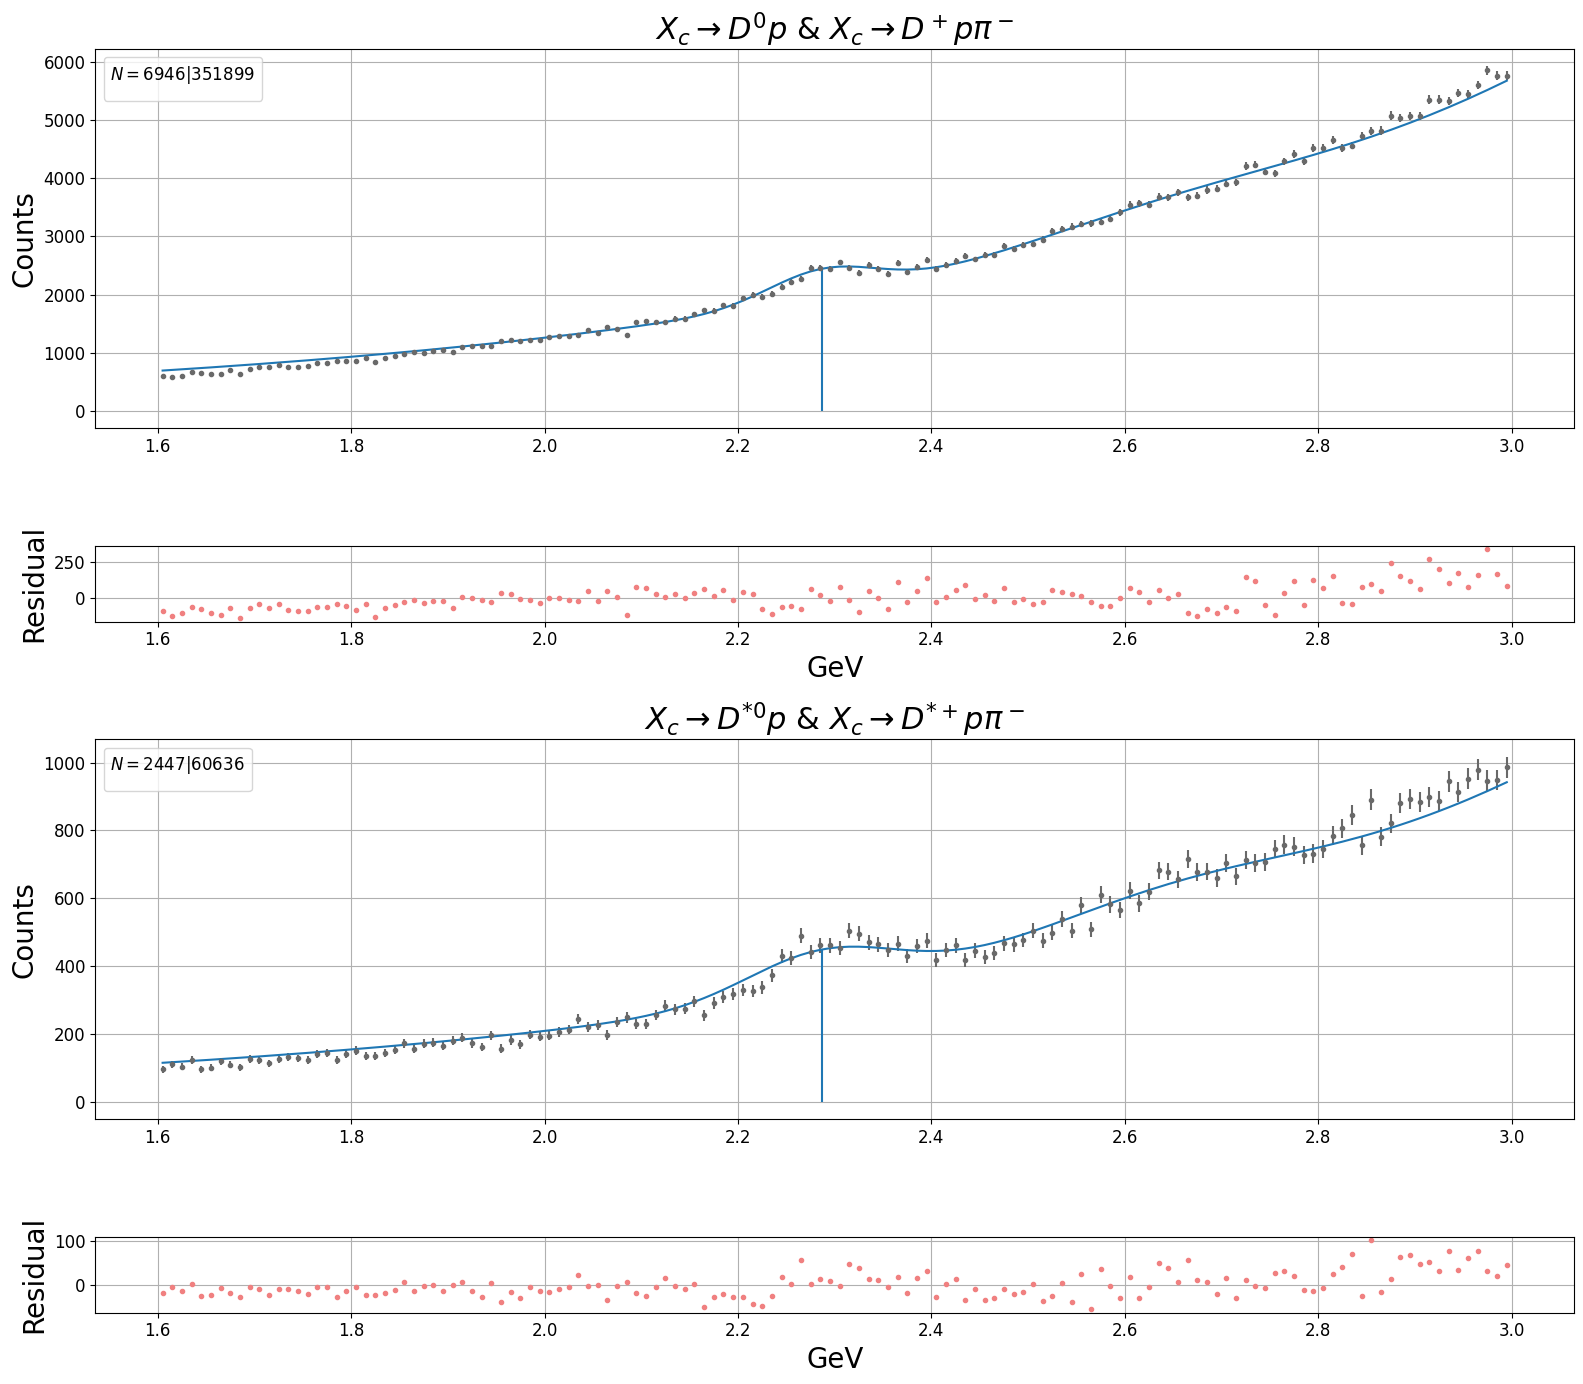

In [57]:
import numpy as np
import matplotlib.pyplot as plt

nbins = 200
wbin = 0.01

# Create a figure with 4 subplots arranged in a single column
fig, axs = plt.subplots(4, 1, figsize=(16, 14), gridspec_kw={'height_ratios': [1, 0.2, 1, 0.2]})  # Adjusted height ratios and figure size

for ind, i in enumerate([(1, 2), (3, 4)]):
    dat = inc[(inc.rm2l < b) & (inc.rm2l > a) & (inc.ntr <= 3) & (inc.chxc.isin(i)) & (
              ((inc.chxc >= 3) & (np.abs(inc.dsm - inc.dm - 0.142014) < 0.003)) |
              ((inc.chxc <= 2) & (np.abs(inc.dm - D_0_m) < 0.015)))]    
    counts, bin_edges = np.histogram(dat.rm2l, bins=int((b-a)/wbin))
    bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2
    N = dat.shape[0]
    if ind == 0:
        args = (0.1, 0.9, 1.5, 1,  0.05,  0.1)
    else:
        args = (0.06, 0.9, 1.5, 1,  0.05,  0.1)
    bounds = [(0, 1), (0, 1), (1, 2), (-1, 3), (0, 0.1), (0, 0.2)]
    
    # Main plot
    ax_main = axs[ind * 2]
    ax_main.errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt='.', color='dimgrey')
    args, normm = max_bin_lik(f_lam, bin_centers, counts, args, h=1e-11, bounds=bounds)
    title = " & ".join([decay_mod_taging[_-1] for _ in i])
    norm = N * wbin
    ax_main.vlines(Lamc_m, f_lam(Lamc_m, *args)*norm, 0)
    ax_main.plot(bin_centers, f_lam(bin_centers, *args)*norm)
    ax_main.legend(title=f"$N = {N}$")
    ax_main.set_title(title)
    ax_main.set_ylabel('Counts')
    ax_main.grid()

    ax_main.legend(title = f"$N = {int(args[0]*N)} | {N}$")

    # Residuals plot (below each main plot)
    residuals = counts - f_lam(bin_centers, *args) * norm
    ax_resid = axs[ind * 2 + 1]
    ax_resid.plot(bin_centers, residuals, '.', color='lightcoral')
    ax_resid.set_xlabel('GeV')
    ax_resid.set_ylabel('Residual')
    ax_resid.set_xlim(ax_main.get_xlim())  # Sync x-axis limits with main plot
    ax_resid.grid()
    
plt.tight_layout()
plt.savefig(f"{path}inc_fit.png")
plt.show()


In [58]:
data = [re, mc]

In [59]:
mc["chxc"] = pd.to_numeric(mc["chxc"])
mc["chlc"] = pd.to_numeric(mc["chlc"])
chxc = int(mc.chxc.max())


In [60]:
decay_mod_taging = ["$X_c \\to D^0 p$", "$X_c \\to D^+ p \\pi^- $", "$X_c \\to D^{*0} p$", "$X_c \\to D^{*+} p \\pi^-$", "$X_c \\to \\Lambda_c^- \\pi^- \\pi^+$"]
decay_mod_tag = {"\\Lambda \\nu_l l": [lambda x: x <= 2, "L_nu_l"], "\\Lambda \\pi" : [lambda x: x == 3, "L_pi"], "p K \\pi" : [lambda x: x == 5, "p_k_pi"]}

In [61]:
D_star_0_gamm_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.010) & (dt.chach == 2) & (dt.chxc == 3)
D_star_0_pi_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.003) & (dt.chach == 1) & (dt.chxc == 3)
D_star_pm_pi_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.003) & ((dt.chach == 1) | (dt.chach == 2)) & (dt.chxc == 4)
D_star_mask = lambda dt: D_star_0_gamm_mask(dt) | D_star_0_pi_mask(dt) | D_star_pm_pi_mask(dt) | (dt.chxc == 1) | (dt.chxc == 2)
Lambda_c_mass_mask = lambda dt: np.abs(dt.mlc) < 0.015 
Privalov_cut = lambda dt: (np.abs(dt.p) < 0.05) & (np.abs(dt.e - dt.ecm) < 0.05)

TypeError: Axes.errorbar() missing 1 required positional argument: 'y'

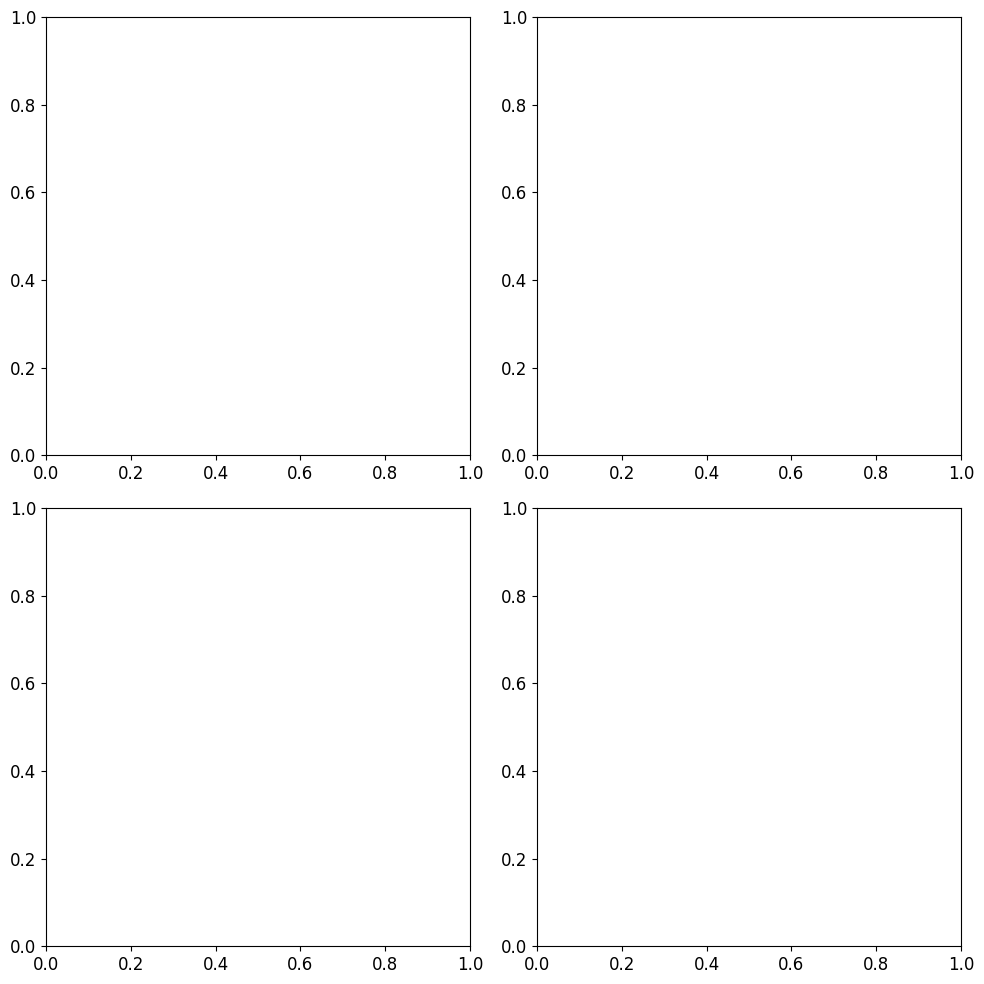

In [62]:
n = int(np.ceil(chxc**0.5))
wbin = 0.025
j = 0

for lam_cl, (condition, label) in decay_mod_tag.items():
    fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
    fig.tight_layout()
    for i in range(chxc):
        dt = firs
        dat = dt[(dt.chxc == i + 1) & (np.abs(dt.rm2l - Lamc_m) < 0.5) & (condition(dt.chlc))]
        dt = re
        datt = dt[(dt.chxc == i + 1) & (np.abs(dt.rm2l - Lamc_m) < 0.5) & (condition(dt.chlc))]
        diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), int((-min(dat["rm2l"])+max(dat["rm2l"]))/wbin))
        axs[i // n, i % n].errorbar(datt["rm2l"], bins=diw, alpha=0.7, label = "mass fit")
        axs[i // n, i % n].errorbar(dat["rm2l"], bins=diw, alpha=0.7, label = "original")
        axs[i//n, i%n].legend()
        axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
        axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}/GeV$", fontsize=20, loc='right')
        axs[i//n, i%n].set_xlim([Lamc_m-0.5, Lamc_m+0.5])

    if j == 0:
        fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ data$", fontsize=24)
        
        fig.savefig(f"{path}{label}_data.png")
    else:
        fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
        fig.savefig(f"{path}{label}_mc.png")
    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


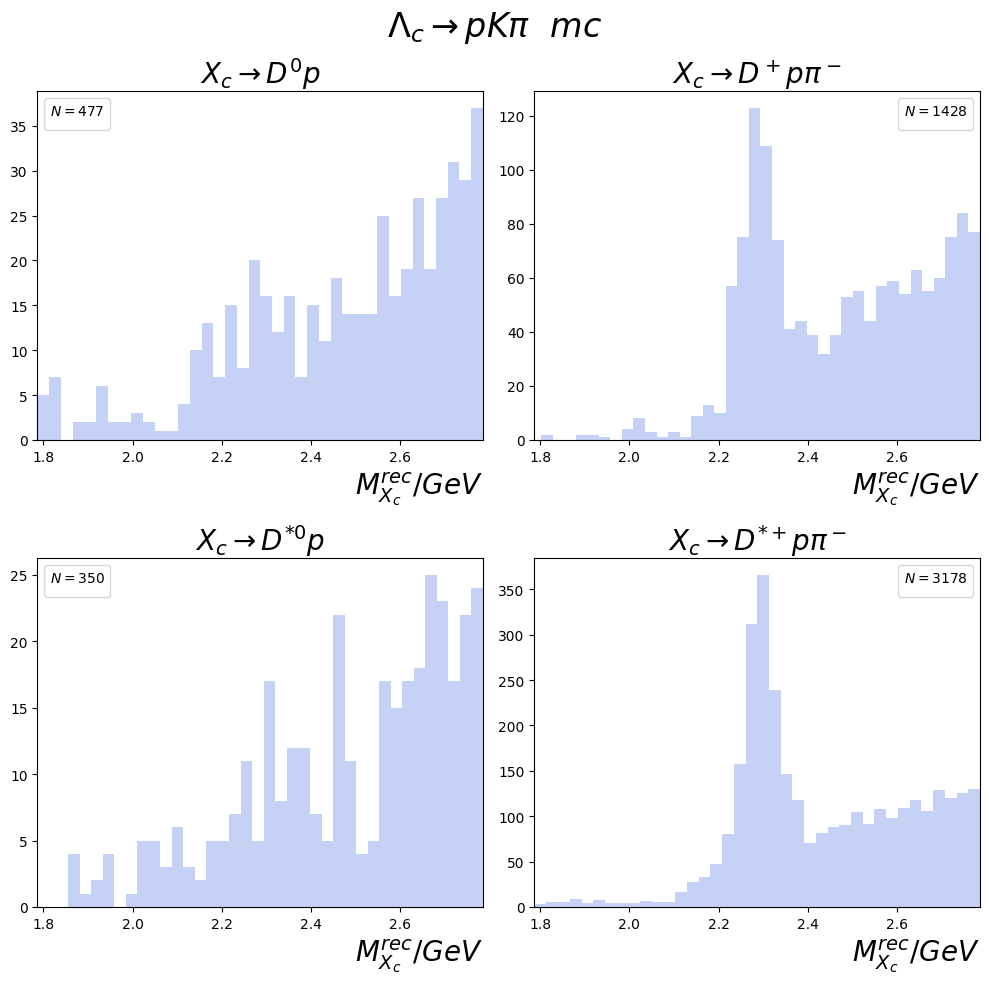

In [ ]:
n = int(np.ceil(chxc**0.5))
wbin = 0.025

j = 1
lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]
condition = decay_mod_tag[lam_cl][0]
fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
for i in range(chxc):
    dat = dt[(dt.chxc == i + 1) & (np.abs(dt.rm2l - Lamc_m) < 0.5) & (condition(dt.chlc))]
    diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), int((-min(dat["rm2l"])+max(dat["rm2l"]))/wbin))
    N = dat.shape[0]
    axs[i//n, i%n].legend(title = f"$N = {N}$")
    axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(dat["rm2l"], bins=diw, alpha=0.3, color="royalblue")

    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}/GeV$", fontsize=20, loc='right')
    axs[i//n, i%n].set_xlim([Lamc_m-0.5, Lamc_m+0.5])

if j == 0:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    
    fig.savefig(f"{path}{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    fig.savefig(f"{path}{label}_re.png")
plt.tight_layout()
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


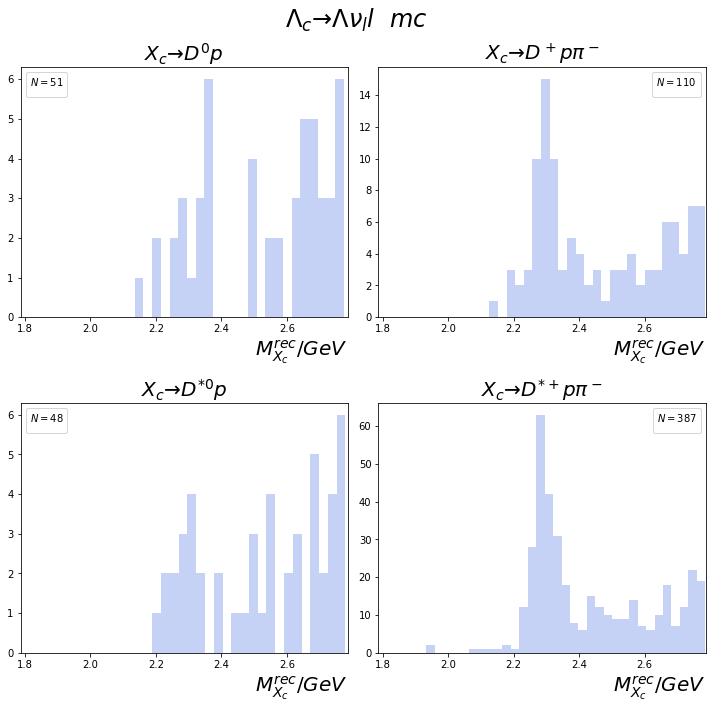

In [ ]:
n = int(np.ceil(chxc**0.5))
wbin = 0.025

j = 1
lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]
condition = decay_mod_tag[lam_cl][0]
fig, axs = plt.subplots(chxc // n if chxc % n == 0 else chxc // n + 1, n, figsize=(5 * n, 5 * chxc // n if chxc % n == 0 else 5 * (chxc // n + 1)))
for i in range(chxc):
    dat = dt[(dt.chxc == i + 1) & (np.abs(dt.rm2l - Lamc_m) < 0.5) & (condition(dt.chlc)) & (dt.tr_ach) & (dt.tr_lc)]
    diw = np.linspace(min(dat["rm2l"]), max(dat["rm2l"]), int((-min(dat["rm2l"])+max(dat["rm2l"]))/wbin))
    N = dat.shape[0]
    axs[i//n, i%n].legend(title = f"$N = {N}$")
    axs[i // n, i % n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(dat["rm2l"], bins=diw, alpha=0.3, color="royalblue")
    #if j == 1:
    #    dat = dt[(dt.chxc == i + 1) &  (condition(dt.chlc)) & (abs(Lamc_m - dt.rm2l) <= 0.6) & additional_mask & mask]
    #    axs[i // n, i % n].hist(dat["rm2l"], bins=nbins, alpha=0.3, color="dimgray")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}/GeV$", fontsize=20, loc='right')
    axs[i//n, i%n].set_xlim([Lamc_m-0.5, Lamc_m+0.5])

if j == 0:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    
    fig.savefig(f"{path}{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    fig.savefig(f"{path}{label}_re.png")
plt.tight_layout()
plt.show()

In [100]:

def convolution_meshed(x, g, f, fargs, gargs, delta = 0.1, N = 1000, mesh = None):
    # Оптимизированная функция поиска свертки двух функций опреденных на x
    # Условие применимости 
    # f - синальная функция на X и локализованная в центре X, пик узкий (хотя он может быть не один) если нет то надо расширить S
    # g - функция фонов, определена на S - mean(X)
    # S содержит X-mean(X) так чтобы for all xi in (X-mean(X))/S, x' in x => f(xi-x) << 1
    # Кароче s = [min(x)-delta, max(x)+delta] где delta полуширина пика   
    mu = np.mean(x)
    if not(mesh is None):
        x, s = np.meshgrid(x, mesh)
    else:
        x, s = np.meshgrid(x, np.linspace(np.min(x) - mu - delta, np.max(x) - mu + delta, N))
    return np.sum(g(s, *fargs)*f(x-s, *gargs), axis=0)/N

In [105]:
sq = njit(lambda x, c1, c2, b1, a1: c1 * np.sqrt((x - Pi_0_m) * heaviside(x, Pi_0_m)) * (1 + a1*eval_chebyt(1, x))  + c2 * np.sqrt(x * heaviside(x, 0)) * (1 + b1*eval_chebyt(1, x)))

signal_lam = njit(lambda x, mass1, A2, sigma1, sigma2: A2*gaussian(x, mass1, sigma1) + (1-A2)*gaussian(x, Lamc_m, sigma2))

def continuum_lam(x, mass1, A2, sigma1, sigma2, c0, c1, c2, b1, a1):
    return convolution_meshed(x, sq, signal_lam, [c1, c2, b1, a1], [mass1, A2, sigma1, sigma2], max(sigma1, sigma2)*10, mesh=np.linspace(-1, 1, 700)) + c0

f_lam = lambda x, A1, mass1, A2, sigma1, sigma2, c0, c1, c2, b1, a1: A1*signal_lam(x, mass1, A2, sigma1, sigma2) + (1-A1)*continuum_lam(x, mass1, A2, sigma1, sigma2, c0, c1, c2, b1, a1)

In [106]:
num_cores = multiprocessing.cpu_count()
print(f"Доступно ядер: {num_cores}")

Доступно ядер: 16


In [107]:
def process_channel(i, dt, Lamc_m, decay_mod_taging, label, j, res):
    try:
        mask = (dt.chlc <= 2) & (np.abs(dt.rm2l - Lamc_m) < 0.5)

        dat = dt[(dt.chxc == i + 1) & mask]

        counts, bin_edges = np.histogram(dat.rm2l, bins=150)
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

        if f"fit_{label}_{decay_mod_taging[i]}_{j}" in res:
            args = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1]
        else:
            args = (2.5e-01, Lamc_m, 0.1, 1e-02, 1e-02, 1e-01, 5e-01, 5e-01, 0, 0)
        bounds = ((0, 1), (Lamc_m - 0.01, Lamc_m + 0.05), (0, 1), (0, 0.04), (0, 0.04), (0, 2), (0, 2), (0, 2), (-10, 10), (-10, 10))

        args, normm = max_bin_lik(f_lam, bin_centers, counts, args, bounds=bounds)

        ans = {f"fit_{label}_{decay_mod_taging[i]}_{j}" : list([*args, normm])}
        return ans

    except Exception as e:
        return {f"error_{i}": str(e)}

if __name__ == '__main__':
    lam_cl = "\\Lambda \\nu_l l"
    label = decay_mod_tag[lam_cl][1]

    with open('res.json', 'r') as file:
        res = json.load(file)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

    try:
        results = pool.starmap(process_channel, [(i//2, data[i%2], Lamc_m, decay_mod_taging, label, i%2, res) for i in range(2*chxc)])

    except Exception as e:
        print(f"An error occurred during multiprocessing: {e}")

    finally:
        pool.close()
        pool.join()

    for result in results:
        if isinstance(result, dict):
            for key in result:
                if key.startswith("error_"):
                    print(f"Error in channel {key.split('_')[1]}: {result[key]}")
                else:
                    res[key] = result[key]

    with open('res.json', 'w') as file:
        json.dump(res, file, indent=4)


/home/mar/Documents/data_ref/source.py:112: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)
/home/mar/Documents/data_ref/source.py:112: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)
/home/mar/Documents/data_ref/source.py:112: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)
/home/mar/Documents/data_ref/source.py:112: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, args0, args=(bin_centers, counts), method = method, options={'xatol': h, 'fatol': h}, bounds=bounds)
/home/mar/Documents/data_ref/source.py:112: OptimizeWarning: Unknown solver options: xatol, fatol
  rez = minimize(df, a

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 150.81724212299355
       x: [ 5.267e-04  2.320e+00  1.353e-01  1.986e-02  3.992e-02
            1.861e+00  8.960e-03  6.398e-03 -7.205e-02 -5.769e-02]
     nit: 1
     jac: [-5.913e-04  0.000e+00 -3.815e-06  3.815e-06  1.526e-05
            0.000e+00 -1.678e-04 -2.060e-04  0.000e+00  0.000e+00]
    nfev: 11
    njev: 1

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 157.0042057686968
       x: [ 1.752e-01  2.279e+00  2.432e-01  3.076e-02  3.355e-02
            1.994e+00  4.325e-01  4.209e-01 -2.013e-02 -1.731e-02]
     nit: 8
     jac: [ 8.392e-05 -1.869e-04  7.629e-06  3.815e-06 -2.213e-04
            4.959e-05 -1.183e-04 -1.602e-04 -2.670e-05 -2.289e-05]
    nfev: 89
    njev: 8
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 157.4493308818989
       x: [ 1.187e-01  2.294e+00  1.702e-01  3.723e-02  2.828e-02
            1.874e+0

0.09745118699651745
0.07039807412063204


/tmp/ipykernel_59169/2504175106.py:32: RuntimeWarning: invalid value encountered in sqrt
  sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))


ValueError: cannot convert float NaN to integer

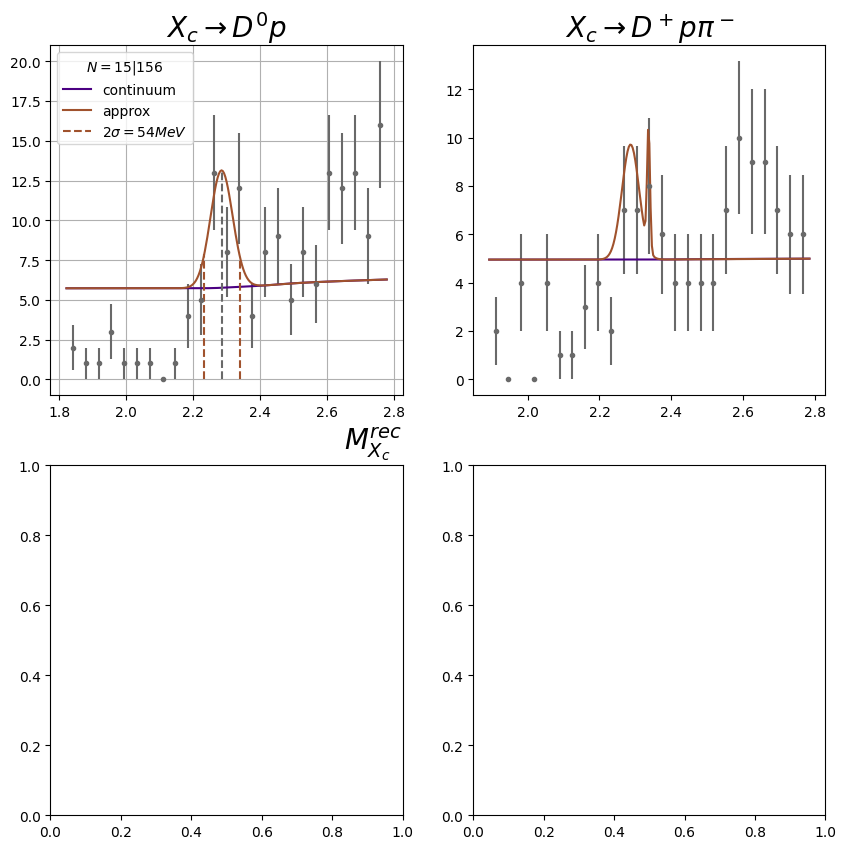

In [109]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 0
dt = data[j]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]
with open('res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    mask = (dt.chlc <= 2)  & (np.abs(dt.rm2l - Lamc_m) < 0.5) 
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((Lamc_m-2*sigmas_12[-1],Lamc_m+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(Lamc_m-2*sigmas_12[-1], *args)*norm/normm, f_lam(Lamc_m+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((Lamc_m), (0), (f_lam(Lamc_m, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()


if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


0.22080746020685926
0.32440572777805987
0.17505669084966435
0.2289984927451153


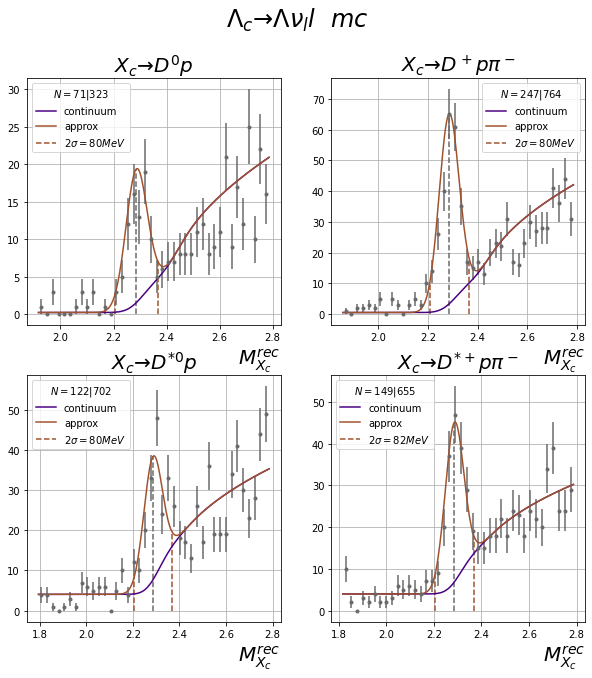

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 40
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 1
dt = data[j]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    mask = (dt.chlc <= 2)  & (np.abs(dt.rm2l - lamc_mass) < 0.5) 
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()


if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


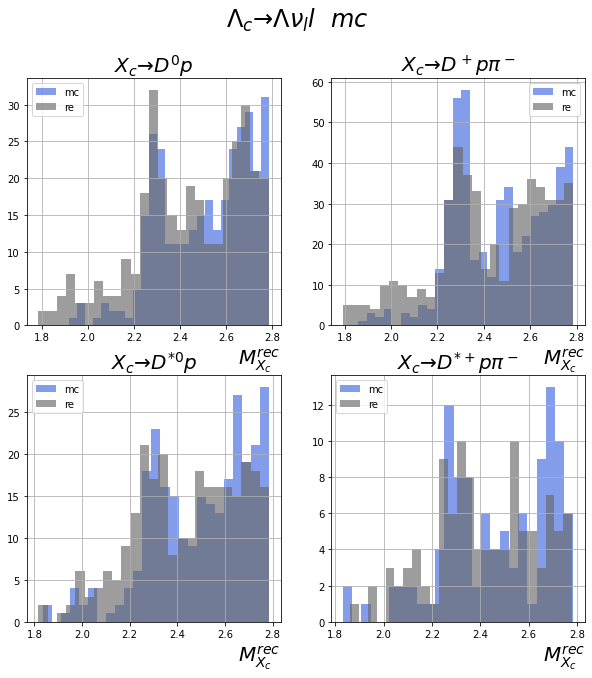

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_re = data[0]
dt_mc = data[1]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]

for i in range(chxc):
    mask_re = (dt_re.chlc <= 2)  & (np.abs(dt_re.rm2l - lamc_mass) < 0.5) 
    mask_mc = (dt_mc.chlc <= 2)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5) 
    re = dt_re[(dt.chxc == i + 1) & mask_re].rm2l
    mc = dt_mc[(dt.chxc == i + 1) & mask_mc].rm2l

    min_size = min(len(mc), len(re))
    if len(mc) > min_size:
        mc = np.random.choice(mc, min_size, replace=False)
    elif len(re) > min_size:
        re = np.random.choice(re, min_size, replace=False)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


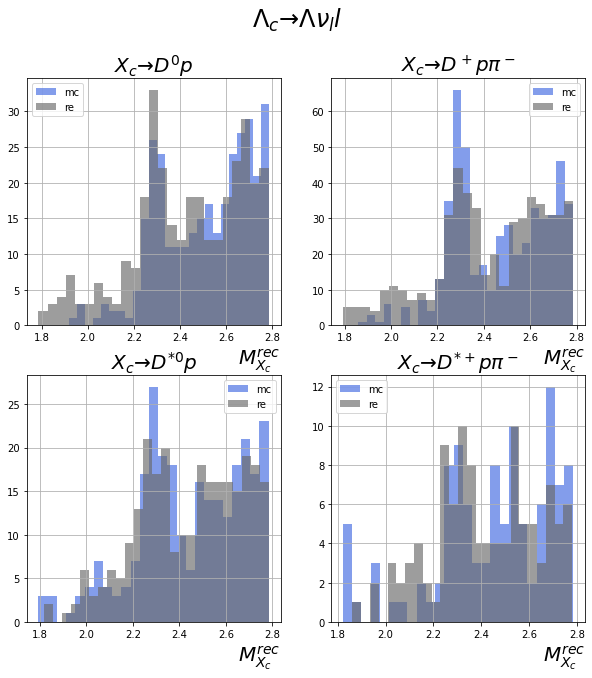

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_re = data[0]
dt_mc = data[1]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]

for i in range(chxc):
    mask_re = (dt_re.chlc <= 2)  & (np.abs(dt_re.rm2l - lamc_mass) < 0.5) 
    mask_mc = (dt_mc.chlc <= 2)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5) 
    re = dt_re[(dt.chxc == i + 1) & mask_re].rm2l
    mc = dt_mc[(dt.chxc == i + 1) & mask_mc].rm2l

    min_size = min(len(mc), len(re))
    if len(mc) > min_size:
        mc = np.random.choice(mc, min_size, replace=False)
    elif len(re) > min_size:
        re = np.random.choice(re, min_size, replace=False)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()

fig.suptitle(f"$\\Lambda_c \\to {lam_cl}$", fontsize=24)
rm(f"{path}comp_{label}_mc.png")
fig.savefig(f"{path}comp_{label}_mc.png")

plt.show()


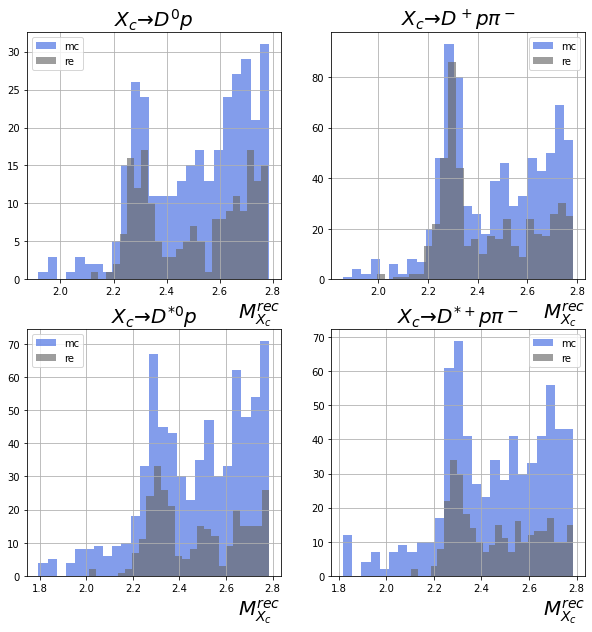

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_mc = data[1]

lam_cl = "\\Lambda \\nu_l l"
label = decay_mod_tag[lam_cl][1]


for i in range(chxc):
    mask_mc = (dt_mc.chlc <= 2)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5)
    re = dt_mc[(dt_mc.chxc == i + 1) & mask_mc & dt_mc.tr_ach].rm2l
    mc = dt_mc[(dt_mc.chxc == i + 1) & mask_mc].rm2l


    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()

In [ ]:
D_star_0_gamm_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.010) & (dt.chach == 2) & (dt.chxc == 3)
D_star_0_pi_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.003) & (dt.chach == 1) & (dt.chxc == 3)
D_star_pm_pi_mask = lambda dt: (np.abs(dt.mach - dt.machdt) < 0.003) & ((dt.chach == 1) | (dt.chach == 2)) & (dt.chxc == 4)
D_star_mask = lambda dt: D_star_0_gamm_mask(dt) | D_star_0_pi_mask(dt) | D_star_pm_pi_mask(dt) | (dt.chxc == 1) | (dt.chxc == 2)
Lambda_c_mass_mask = lambda dt: np.abs(dt.mlc) < 0.015 
Privalov_cut = lambda dt: (np.abs(dt.p) < 0.05) & (np.abs(dt.e - dt.ecm) < 0.05)

In [ ]:
def process_channel(i, dt, lamc_mass, decay_mod_taging, label, j, res):
    try:
        mask = (dt.chlc == 5) & (np.abs(dt.rm2l - lamc_mass) < 0.5)
        add_mask = D_star_mask(dt) & Lambda_c_mass_mask(dt)

        dat = dt[(dt.chxc == i + 1) & mask ]

        counts, bin_edges = np.histogram(dat.rm2l, bins=150)
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

        if f"fit_{label}_{decay_mod_taging[i]}_{j}" in res:
            args = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1]
        else:
            args = (2.5e-01, lamc_mass, 0.1, 1e-02, 1e-02, 1e-01, 5e-01, 5e-01, 0, 0)
        bounds = ((0, 1), (lamc_mass - 0.01, lamc_mass + 0.05), (0, 1), (0, 0.04), (0, 0.04), (0, 2), (0, 2), (0, 2), (-10, 10), (-10, 10))

        args, normm = max_bin_lik(f_lam, bin_centers, counts, args, bounds=bounds)

        ans = {f"fit_{label}_{decay_mod_taging[i]}_{j}" : list([*args, normm])}
        return ans

    except Exception as e:
        return {f"error_{i}": str(e)}

if __name__ == '__main__':
    lam_cl = "p K \\pi"
    label = decay_mod_tag[lam_cl][1]

    with open('Mat_belle/res.json', 'r') as file:
        res = json.load(file)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

    try:
        results = pool.starmap(process_channel, [(i//2, data[i%2], lamc_mass, decay_mod_taging, label, i%2, res) for i in range(2*chxc)])

    except Exception as e:
        print(f"An error occurred during multiprocessing: {e}")

    finally:
        pool.close()
        pool.join()

    for result in results:
        if isinstance(result, dict):
            for key in result:
                if key.startswith("error_"):
                    print(f"Error in channel {key.split('_')[1]}: {result[key]}")
                else:
                    res[key] = result[key]

    with open('Mat_belle/res.json', 'w') as file:
        json.dump(res, file, indent=4)


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/

     fun: 150.1695272179614
     jac: array([ 7.32421875e-04,  1.37329102e-04,  7.62939453e-06, -4.68063354e-03,
       -2.09484100e-02, -1.06811523e-04,  2.80380249e-04,  2.84194946e-04,
        4.38690186e-05,  2.28881836e-05])
 message: 'Optimization terminated successfully'
    nfev: 23
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.01811664,  2.27648489,  0.15213026,  0.04      ,  0.04      ,
        2.        ,  0.29744522,  0.40392893, -0.04442099, -0.03914425])

     fun: 152.3785386681298
     jac: array([ 7.47680664e-04,  2.47955322e-04, -1.90734863e-06, -3.06510925e-03,
       -9.24110413e-03, -4.76837158e-05,  1.31607056e-04,  9.72747803e-05,
        4.00543213e-05,  1.14440918e-05])
 message: 'Optimization terminated successfully'
    nfev: 33
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([ 0.0270771 ,  2.27646   ,  0.17835567,  0.04      ,  0.04      ,
        2.        ,  0.15387812,  0.52825255, -0.09676879, -0.10245167])
   

0.2672640442018479
0.3462868751430036
0.1911102932398525
0.2609210749492695


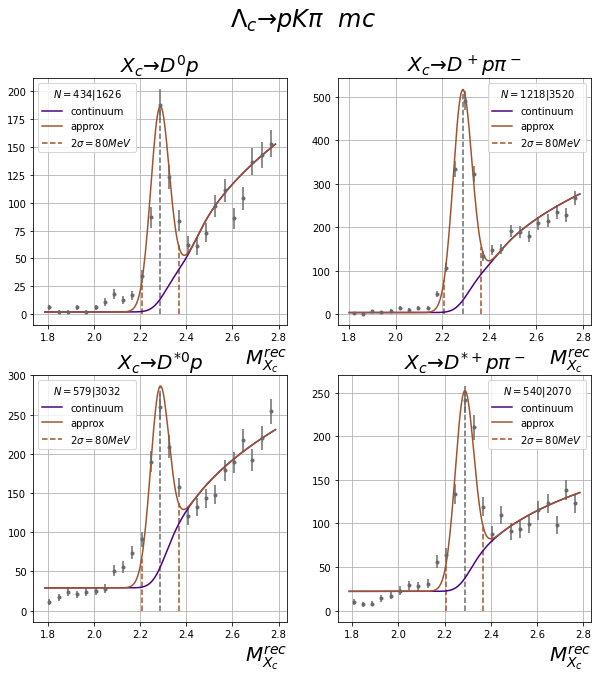

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 1
dt = data[j]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    add_mask = Lambda_c_mass_mask(dt) & D_star_mask(dt)
    mask = (dt.chlc == 5)  & (np.abs(dt.rm2l - lamc_mass) < 0.5)
    dat = dt[(dt.chxc == i + 1) & mask]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


0.18620971121421614
0.20321505683312302
0.13229393421773927
0.1415441118606865
The file does not exist


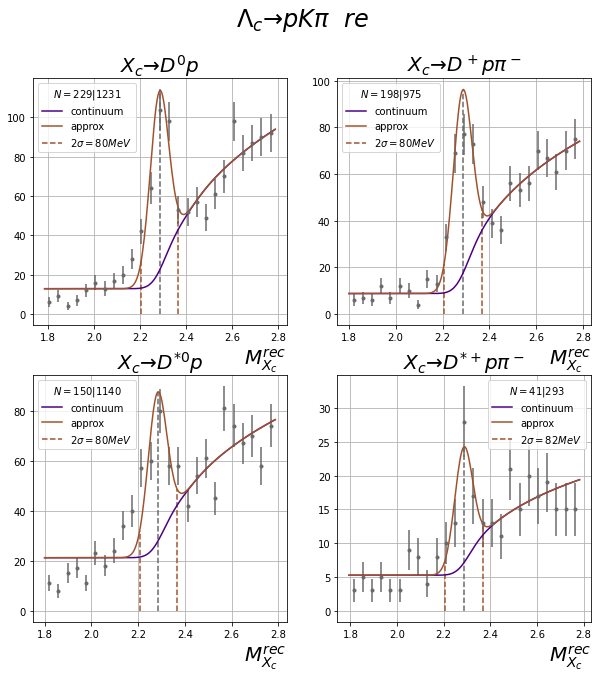

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 0
dt = data[j]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    add_mask = Lambda_c_mass_mask(dt) & D_star_mask(dt)
    mask = (dt.chlc == 5)  & (np.abs(dt.rm2l - lamc_mass) < 0.5)
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


The file does not exist


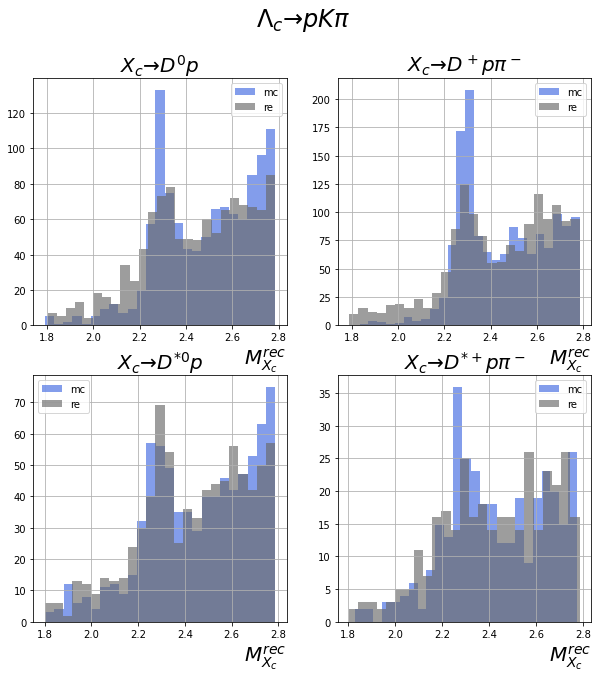

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_re = data[0]
dt_mc = data[1]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]


for i in range(chxc):
    mask_re = (dt_re.chlc == 5)  & (np.abs(dt_re.rm2l - lamc_mass) < 0.5)
    mask_mc = (dt_mc.chlc == 5)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5)
    re = dt_re[(dt.chxc == i + 1) & mask_re].rm2l
    mc = dt_mc[(dt.chxc == i + 1) & mask_mc].rm2l

    min_size = min(len(mc), len(re))
    if len(mc) > min_size:
        mc = np.random.choice(mc, min_size, replace=False)
    elif len(re) > min_size:
        re = np.random.choice(re, min_size, replace=False)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()


fig.suptitle(f"$\\Lambda_c \\to {lam_cl}$", fontsize=24)
rm(f"{path}comp_{label}_re.png")
fig.savefig(f"{path}comp_{label}_re.png")



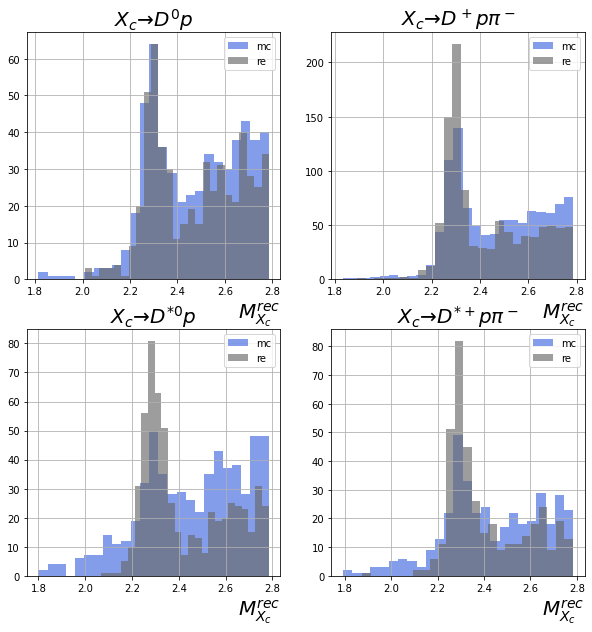

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_mc = data[1]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]


for i in range(chxc):
    add_mask_mc = Lambda_c_mass_mask(dt_mc) & D_star_mask(dt_mc)
    mask_mc = (dt_mc.chlc == 5)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5)
    re = dt_mc[(dt_mc.chxc == i + 1) & mask_mc & dt_mc.tr_ach & dt_mc.tr_lc].rm2l
    mc = dt_mc[(dt_mc.chxc == i + 1) & mask_mc].rm2l


    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()



No handles with labels found to put in legend.
No handles with labels found to put in legend.


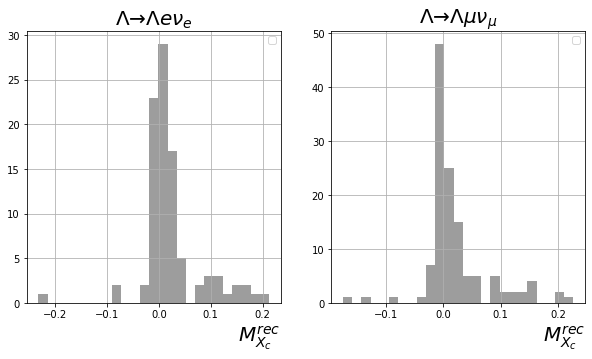

In [ ]:
n = 2
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(1, 2, figsize=(5*n, 5*2//n if 2%n == 0 else 5*(2//n + 1)))
dt_re = data[1]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]
lmc = ["$\\Lambda \\to \\Lambda e \\nu_e$", "$\\Lambda \\to \\Lambda \\mu \\nu_\\mu$"]

for i in [1, 2]:
    mask_re = (dt_re.chlc == i) & (dt_re.ecm > 0.05) & (np.abs(dt_re.nrm2n) < 0.25) & (dt_re.p > 0.05) & (dt_re.q2 > 0) & (dt_re.q2 < 1.37) & (np.abs(dt_mc.rm2l - 2.29) < 0.1)
    re = dt_re[(dt_re.chxc <= 2) & mask_re].nrm2n

    axs[i-1].set_title(lmc[i-1], fontsize=20)
    axs[i-1].hist(re, bins=nbins, alpha=0.65, color="dimgray")
    axs[i-1].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i-1].legend()
    axs[i-1].grid()



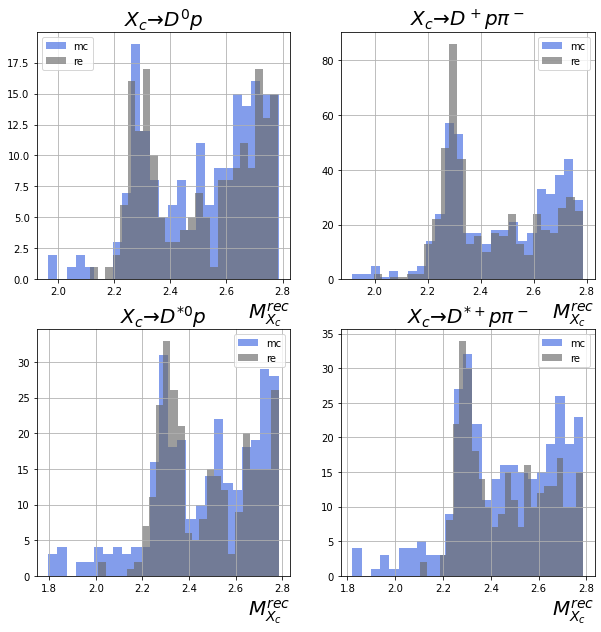

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
dt_mc = data[1]

lam_cl = "p K \\pi"
label = decay_mod_tag[lam_cl][1]


for i in range(chxc):
    add_mask_mc = Lambda_c_mass_mask(dt_mc) & D_star_mask(dt_mc)
    mask_mc = (dt_mc.chlc <= 2)  & (np.abs(dt_mc.rm2l - lamc_mass) < 0.5)
    re = dt_mc[(dt_mc.chxc == i + 1) & mask_mc & dt_mc.tr_ach].rm2l
    mc = dt_mc[(dt_mc.chxc == i + 1) & mask_mc].rm2l

    min_size = min(len(mc), len(re))
    if len(mc) > min_size:
        mc = np.random.choice(mc, min_size, replace=False)
    elif len(re) > min_size:
        re = np.random.choice(re, min_size, replace=False)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i // n, i % n].hist(mc, bins=nbins, alpha=0.65, color="royalblue", label = "mc")
    axs[i // n, i % n].hist(re, bins=nbins, alpha=0.65, color="dimgray", label = "re")
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend()
    axs[i//n, i%n].grid()



In [ ]:
def process_channel(i, dt, lamc_mass, decay_mod_taging, label, j, res):
    try:
        mask = (dt.chlc == 3) & (np.abs(dt.rm2l - lamc_mass) < 0.5)

        dat = dt[(dt.chxc == i + 1) & mask]

        counts, bin_edges = np.histogram(dat.rm2l, bins=150)
        bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2

        if f"fit_{label}_{decay_mod_taging[i]}_{j}" in res:
            args = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1]
        else:
            args = (2.5e-01, lamc_mass, 0.1, 1e-02, 1e-02, 1e-01, 5e-01, 5e-01, 0, 0)
        bounds = ((0, 1), (lamc_mass - 0.01, lamc_mass + 0.05), (0, 1), (0, 0.04), (0, 0.04), (0, 2), (0, 2), (0, 2), (-10, 10), (-10, 10))

        args, normm = max_bin_lik(f_lam, bin_centers, counts, args, bounds=bounds)

        ans = {f"fit_{label}_{decay_mod_taging[i]}_{j}" : list([*args, normm])}
        return ans

    except Exception as e:
        return {f"error_{i}": str(e)}

if __name__ == '__main__':
    lam_cl = "\\Lambda \\pi"
    label = decay_mod_tag[lam_cl][1]

    with open('Mat_belle/res.json', 'r') as file:
        res = json.load(file)

    pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())

    try:
        results = pool.starmap(process_channel, [(i//2, data[i%2], lamc_mass, decay_mod_taging, label, i%2, res) for i in range(2*chxc)])

    except Exception as e:
        print(f"An error occurred during multiprocessing: {e}")

    finally:
        pool.close()
        pool.join()

    for result in results:
        if isinstance(result, dict):
            for key in result:
                if key.startswith("error_"):
                    print(f"Error in channel {key.split('_')[1]}: {result[key]}")
                else:
                    res[key] = result[key]

    with open('Mat_belle/res.json', 'w') as file:
        json.dump(res, file, indent=4)


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  
/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  


     fun: 162.91250289627138
     jac: array([-4.39643860e-03, -2.02178955e-04,  2.86102295e-05, -7.51495361e-04,
       -6.10542297e-03,  0.00000000e+00,  1.30271912e-03,  1.37329102e-04,
        2.09808350e-05,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 15
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 1.02152347e-03,  2.27725753e+00,  8.64212851e-02,  4.00000000e-02,
        3.99881077e-02,  1.92251731e+00,  3.32213147e-15,  3.46125069e-02,
       -1.22756156e-01, -8.52819747e-02])


/gpfs/home/belle2/matrk/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:8: OptimizeWarning: Unknown solver options: xatol, fatol
  


     fun: 191.07340553166347
     jac: array([ 3.62396240e-05,  8.18252563e-04, -3.81469727e-05, -2.17056274e-03,
       -9.17816162e-03, -3.81469727e-05,  1.67846680e-04,  1.06811523e-04,
        1.52587891e-05, -1.90734863e-06])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.02024073,  2.27646   ,  0.20362938,  0.04      ,  0.04      ,
        2.        ,  0.07335605,  0.66861903, -0.05784597, -0.07332873])

     fun: 175.55890466399484
     jac: array([-6.48498535e-04,  5.21087646e-03, -1.20162964e-04, -1.66358948e-02,
       -3.39012146e-02, -1.81198120e-04,  3.87191772e-04,  3.58581543e-04,
        1.06811523e-04,  5.91278076e-05])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.01401435,  2.27646   ,  0.34556005,  0.04      ,  0.04      ,
        2.        ,  0.3981279 ,  0.61646736, -0.01975225, -0.02801533])
 

0.18398870301224646
0.16415880412761896
0.1517487832816482


0.162963672666674
The file does not exist


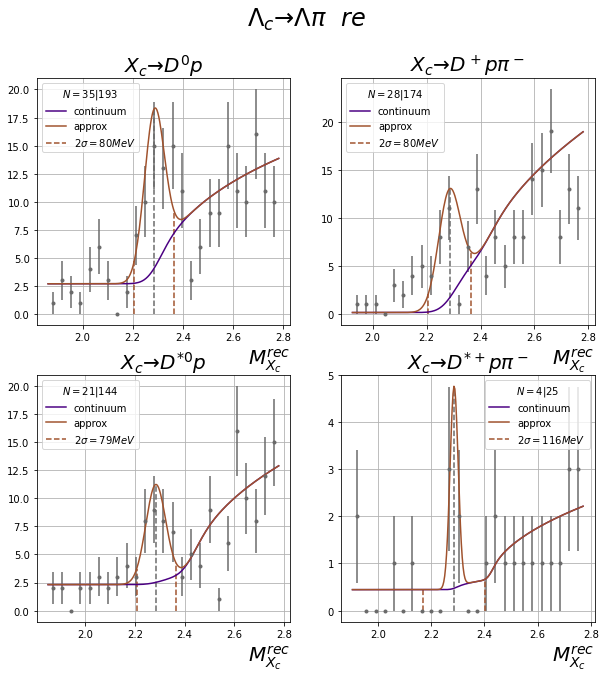

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 0
dt = data[j]

lam_cl = "\\Lambda \\pi"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    add_mask = Lambda_c_mass_mask(dt) & D_star_mask(dt)
    mask = (dt.chlc == 3)  & (np.abs(dt.rm2l - lamc_mass) < 0.5)
    dat = dt[(dt.chxc == i + 1) & mask ]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()


0.25781955135662915
0.3172717261307616
0.17185682474057662
0.208083831442198


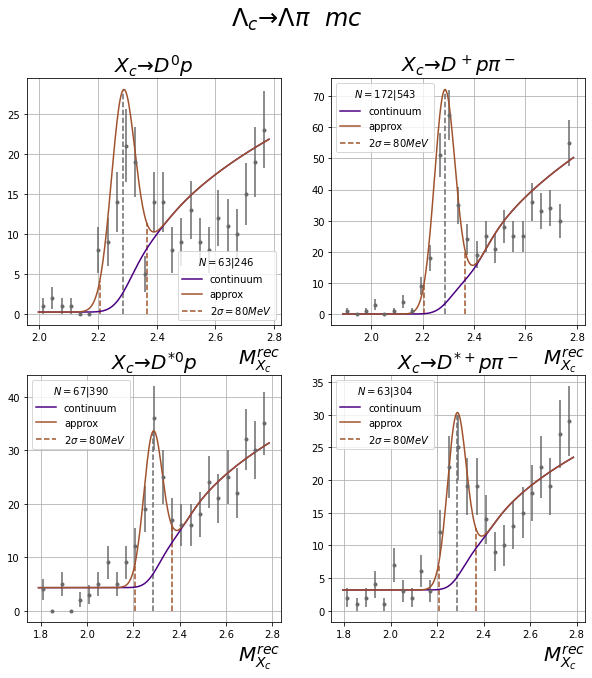

In [ ]:
n = int(np.ceil(chxc**0.5))
nbins = 25
sigmas_12 = list()
fig, axs = plt.subplots(chxc//n if chxc%n == 0 else chxc//n + 1, n, figsize=(5*n, 5*chxc//n if chxc%n == 0 else 5*(chxc//n + 1)))
j = 1
dt = data[j]

lam_cl = "\\Lambda \\pi"
label = decay_mod_tag[lam_cl][1]
with open('Mat_belle/res.json', 'r') as file:
    res = json.load(file)

for i in range(chxc):
    add_mask = Lambda_c_mass_mask(dt) & D_star_mask(dt)
    mask = (dt.chlc == 3)  & (np.abs(dt.rm2l - lamc_mass) < 0.5)
    dat = dt[(dt.chxc == i + 1) & mask]

    norm = dat.rm2l.shape[0]/nbins
    counts, bin_edges = np.histogram(dat.rm2l, bins=nbins)
    x = np.linspace(np.min(bin_edges), np.max(bin_edges), 251)
    bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
    axs[i//n, i%n].errorbar(bin_centers, counts, yerr=np.sqrt(counts), fmt ='.', color = 'dimgrey')

    args, normm = res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][:-1], res[f"fit_{label}_{decay_mod_taging[i]}_{j}"][-1]
    in_sig = 1 - np.sum(continuum_lam(x, *args[1:])*(1-args[0]))/np.sum(f_lam(x, *args))
    print(in_sig)
    tau = args[0]
    axs[i//n, i%n].plot(x, continuum_lam(x, *args[1:])*(1-tau)*norm/normm, color = 'indigo', label = "continuum")
    axs[i//n, i%n].plot(x, f_lam(x, *args)*norm/normm, color = 'sienna', label = "approx")
    s1 = args[3]
    s2 = args[4]
    tau2 = args[1]
    sigmas_12.append(sqrt(tau2*s1**2 + (1-tau2)*s2**2))

    res[f"fit_{label}_{decay_mod_taging[i]}_{j}"] = list(args)

    axs[i//n, i%n].set_title(decay_mod_taging[i], fontsize=20)
    axs[i//n, i%n].vlines((lamc_mass-2*sigmas_12[-1],lamc_mass+2*sigmas_12[-1]), (0, 0), 
                        (f_lam(lamc_mass-2*sigmas_12[-1], *args)*norm/normm, f_lam(lamc_mass+2*sigmas_12[-1], *args)*norm/normm), 
                        linestyle = '--', color = 'sienna', label = f"$2\\sigma = {round(2*sigmas_12[-1]*1000)} MeV$")
    axs[i//n, i%n].vlines((lamc_mass), (0), (f_lam(lamc_mass, *args)*norm/normm), linestyle = '--', color = 'dimgrey')
    axs[i//n, i%n].set_xlabel("$M^{rec}_{X_c}$", fontsize=20, loc='right')
    axs[i//n, i%n].legend(title = f"$N = {int(in_sig*dat.rm2l.shape[0])} | {dat.rm2l.shape[0]}$")
    axs[i//n, i%n].grid()

if j == 1:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ mc$", fontsize=24)
    rm(f"{path}fit_{label}_mc.png")
    fig.savefig(f"{path}fit_{label}_mc.png")
else:
    fig.suptitle(f"$\\Lambda_c \\to {lam_cl} \\ \\ re$", fontsize=24)
    rm(f"{path}{label}_re.png")
    fig.savefig(f"{path}fit_{label}_re.png")
plt.show()
